In [1]:
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D
from tensorflow.keras.layers import Add, Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import ReLU, MaxPool2D, GlobalAvgPool2D, LeakyReLU
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential, save_model, load_model
import numpy as np
from tensorflow.keras.callbacks import TensorBoard
import time
import matplotlib.pyplot as plt
import datetime
import cv2
import os
import tensorflow as tf
import tensorflow.keras
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from pathlib import Path
from tensorflow.keras.utils import to_categorical
from collections import Counter
from plotly.subplots import make_subplots
from tensorflow.keras.layers.experimental import preprocessing as ps
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
import glob
print('tf version', tf.__version__)
print('keras version', tf.keras.__version__)
print('gpu is ','available' if tf.config.list_physical_devices('GPU') else 'not available')

tf version 2.8.0
keras version 2.8.0
gpu is  available


## Convulation layer with BatchNormalization

In [2]:
def conv_layer(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size, 
               strides=strides,
               padding='same',
               use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

## Separable Convulation layer with BatchNormalization

In [3]:
def sep_conv_layer(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        padding='same',
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

## Xception model Entry Flow

In [4]:
def entry_flow(x):
    x = conv_layer(x, filters=32, kernel_size=3, strides=2)
    x = ReLU()(x)
    x = conv_layer(x, filters=64, kernel_size=3)
    tensor = ReLU()(x)
    
    x = sep_conv_layer(tensor, filters=128, kernel_size=3)
    x = ReLU()(x)
    x = sep_conv_layer(x, filters=256, kernel_size=3)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    tensor = conv_layer(tensor, filters=256, kernel_size=1, strides=2)
    
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_conv_layer(x, filters=256, kernel_size=3)
    x = ReLU()(x)
    x = sep_conv_layer(x, filters=256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    tensor = conv_layer(tensor, filters=256, kernel_size=1, strides=2)
    
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_conv_layer(x, filters=512, kernel_size=3)
    x = ReLU()(x)
    x = sep_conv_layer(x, filters=1024, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    tensor = conv_layer(tensor, filters=1024, kernel_size=1, strides=2)
    x = Add()([tensor, x])
    
    return x

## Xception model Middle flow

In [5]:
def middle_flow(tensor):
    for _ in range(4):
        x = ReLU()(tensor)
        x = sep_conv_layer(x, filters=1024, kernel_size=3)
        x = ReLU()(x)
        x = sep_conv_layer(x, filters=1024, kernel_size=3)
        x = ReLU()(x)
        x = sep_conv_layer(x, filters=1024, kernel_size=3)
        x = ReLU()(x)
        x = sep_conv_layer(x, filters=1024, kernel_size=3)
        
        tensor = Add()([tensor, x])
    
    return tensor

## Xception model Exit flow

In [6]:
def exit_flow(tensor):
    x = LeakyReLU()(tensor)
    x = sep_conv_layer(x, filters=1024, kernel_size=3)
    x = LeakyReLU()(tensor)
    x = sep_conv_layer(x, filters=728, kernel_size=3)
    x = LeakyReLU()(x)
    x = sep_conv_layer(x, filters=512, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    tensor = conv_layer(tensor, filters=512, kernel_size=1, strides=2)
    
    x = Add()([tensor, x])
    x = sep_conv_layer(x, filters=512, kernel_size=3)
    x = LeakyReLU()(x)
    x = sep_conv_layer(x, filters=256, kernel_size=3)
    x = LeakyReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(128, activation=tf.keras.layers.LeakyReLU())(x)
    x = Dense(64, activation=tf.keras.layers.LeakyReLU())(x)
    x = Dropout(0.5)(x)
    x = Dense(units=49, activation='softmax')(x)
    
    return x

## Model creation 

In [7]:
input = Input(shape=[128, 128, 3])

x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

base_model = Model(input, output)

In [8]:
num_of_class = 49
epoch = 100

model = Sequential()
model.add(base_model)

model.compile(loss ='categorical_crossentropy', optimizer ='adam', metrics =['accuracy'])

## BDSL Dataset Training 94%

In [9]:
file = open('X_train_128.pkl', 'rb')
X_train = pickle.load(file)

file = open('y_train_128.pkl', 'rb')
y_train = pickle.load(file)

file = open('X_test_128.pkl', 'rb')
X_test = pickle.load(file)

file = open('y_test_128.pkl', 'rb')
y_test = pickle.load(file)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11774, 128, 128, 3)
(11774, 49)
(2940, 128, 128, 3)
(2940, 49)


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 49)                20325577  
                                                                 
Total params: 20,325,577
Trainable params: 20,279,641
Non-trainable params: 45,936
_________________________________________________________________


In [12]:
H = model.fit(
    x=X_train,
    y=y_train,
    batch_size=58,
    epochs=epoch,
    validation_data=(X_test, y_test))

Epoch 1/100
203/203 [==============================] - 82s 364ms/step - loss: 3.3571 - accuracy: 0.1182 - val_loss: 3.8972 - val_accuracy: 0.0204
Epoch 2/100
203/203 [==============================] - 73s 360ms/step - loss: 1.8568 - accuracy: 0.4310 - val_loss: 3.6370 - val_accuracy: 0.1041
Epoch 3/100
203/203 [==============================] - 74s 366ms/step - loss: 0.9119 - accuracy: 0.7082 - val_loss: 1.1836 - val_accuracy: 0.6680
Epoch 4/100
203/203 [==============================] - 74s 367ms/step - loss: 0.5459 - accuracy: 0.8211 - val_loss: 0.8125 - val_accuracy: 0.7459
Epoch 5/100
203/203 [==============================] - 75s 369ms/step - loss: 0.3899 - accuracy: 0.8711 - val_loss: 0.7891 - val_accuracy: 0.7714
Epoch 6/100
203/203 [==============================] - 75s 369ms/step - loss: 0.3003 - accuracy: 0.9013 - val_loss: 1.1858 - val_accuracy: 0.6956
Epoch 7/100
203/203 [==============================] - 75s 369ms/step - loss: 0.2340 - accuracy: 0.9225 - val_loss: 0.5515 -

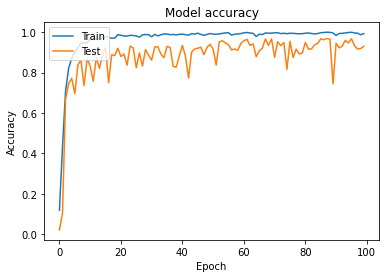

In [13]:
# Plot training & validation accuracy values
fig, ax = plt.subplots(1,1)
plt.plot(H.history["accuracy"])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

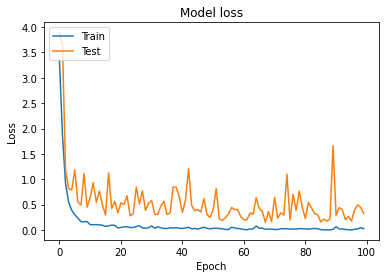

In [14]:
# Plot training & validation loss values
fig, ax = plt.subplots(1,1)
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        60
           1       0.95      0.92      0.93        60
           2       0.94      0.80      0.86        60
           3       0.85      0.78      0.82        60
           4       0.72      0.90      0.80        60
           5       0.88      0.88      0.88        60
           6       1.00      0.93      0.97        60
           7       0.97      0.97      0.97        60
           8       0.92      0.92      0.92        60
           9       0.91      1.00      0.95        60
          10       1.00      0.98      0.99        60
          11       0.97      0.95      0.96        60
          12       0.97      1.00      0.98        60
          13       0.98      0.97      0.97        60
          14       0.96      0.88      0.92        60
          15       0.92      1.00      0.96        60
          16       0.80      0.98      0.88        60
     

Text(249.0, 0.5, 'Predicted')

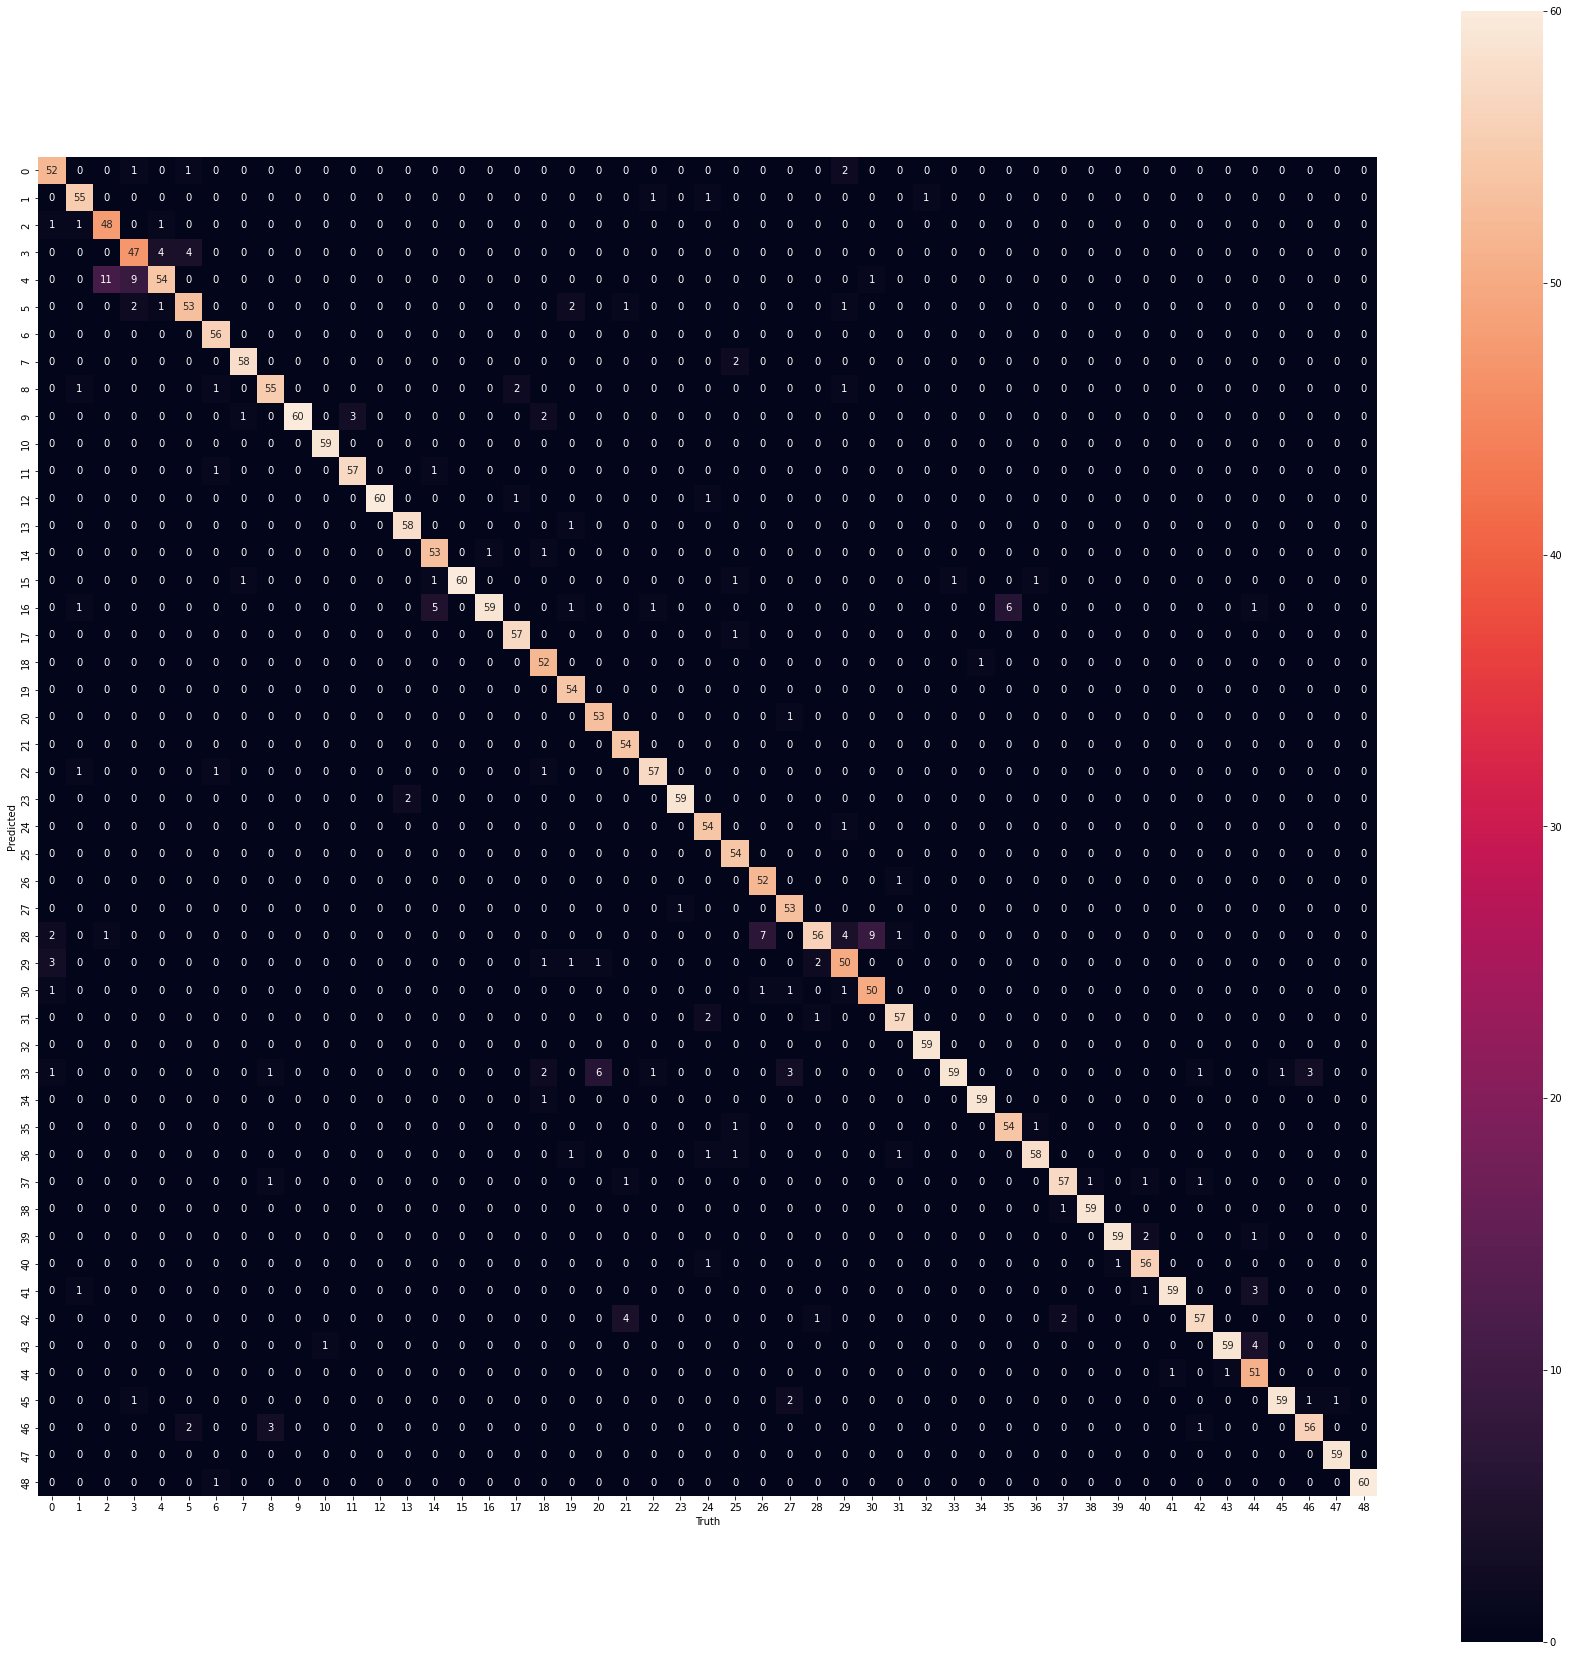

In [15]:
y_pred = np.argmax(model.predict(X_test,batch_size=1), axis=1) 

print('Classification Report')
y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
report = classification_report(y_classes, y_pred)
print(report)

plt.figure(figsize=(30,30))
cm = confusion_matrix(y_classes, y_pred)
_=sns.heatmap(cm.T, annot=True, fmt='d', cbar=True, square=True)
plt.xlabel('Truth')
plt.ylabel('Predicted')